In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = r'Dataset_14-day_AA_depression_symptoms_mood_and_PHQ-9.csv'
df = pd.read_csv(data_path)
df.columns = df.columns.str.strip()

# Calculate total PHQ-9 score if not yet done
phq_columns = ['phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9']
df['phq_total'] = df[phq_columns].sum(axis=1)

# Define the target variable
df['has_mental_health_issues'] = (df['phq_total'] >= 10).astype(int)

# Encode 'sex'
df['sex'] = df['sex'].map({'male': 0, 'female': 1})

# Feature columns
feature_columns = phq_columns + ['age', 'sex']

X = df[feature_columns]
y = df['has_mental_health_issues']

# Separate features by type
numeric_features = phq_columns + ['age']
categorical_features = ['sex']

# Define imputers
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_imputer, numeric_features),
        ('cat', categorical_imputer, categorical_features)
    ])

# Fit and transform
X_imputed = preprocessor.fit_transform(X)

# Convert numeric columns (all except last one here) to int
# numeric features length
num_cols_len = len(numeric_features)

# Convert numeric columns to int and keep categorical as is
X_imputed[:, :num_cols_len] = X_imputed[:, :num_cols_len].astype(int)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Undersample training set only
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Model training
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Cross-validation
cross_val_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validated Accuracy Scores:", cross_val_scores)
print("Mean Cross-Validated Accuracy:", cross_val_scores.mean())

# Model evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)
print("Classification Report:\n", classification_report(y_test, y_pred))


Cross-validated Accuracy Scores: [0.98412698 0.98313492 0.9672619  0.97916667 0.98313492]
Mean Cross-Validated Accuracy: 0.9793650793650792
ROC-AUC Score: 0.997440835492369
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96      1106
           1       1.00      0.98      0.99      3739

    accuracy                           0.98      4845
   macro avg       0.97      0.98      0.97      4845
weighted avg       0.98      0.98      0.98      4845



In [2]:
import shap 
shap.initjs()

background_data =  shap.sample(X_train, 10)

explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer(X_test)

np.shape(shap_values)

C:\Users\kumud\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4845/4845 [01:42<00:00, 47.40it/s]


(4845, 11, 2)

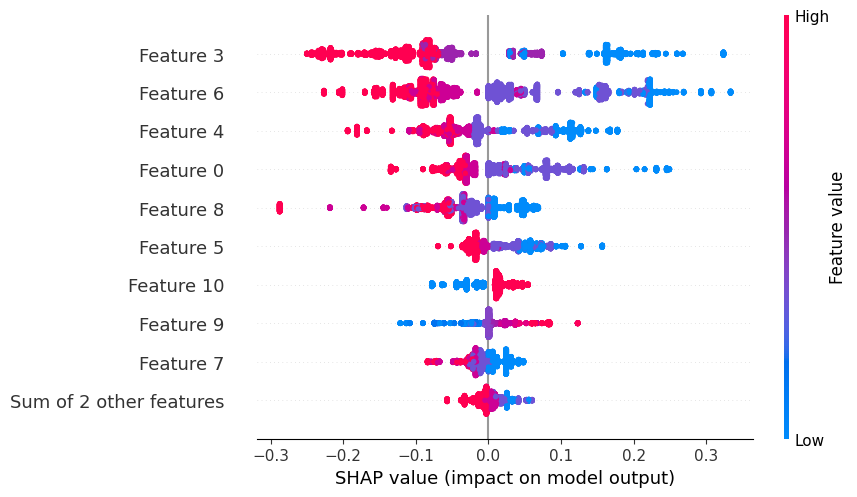

In [3]:
shap.plots.beeswarm(shap_values[:4845,:,0])

Text(0.5, 0, 'phq_total')

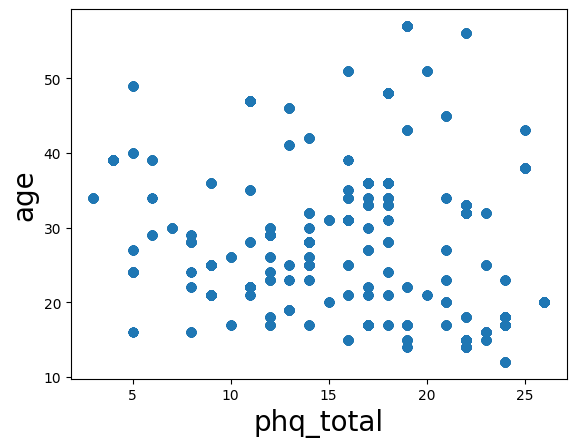

In [4]:
# scatterplot
plt.scatter(df['phq_total'],df['age'])
plt.ylabel('age', size =20)
plt.xlabel("phq_total", size =20)

Text(0, 0.5, 'phq_total')

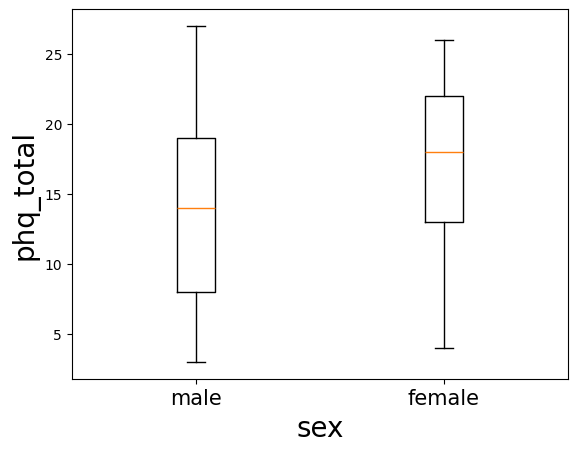

In [5]:
# box_plot
plt.boxplot(df[df.sex == 0]['phq_total'],positions=[1])
plt.boxplot(df[df.sex == 1]['phq_total'],positions=[2])

plt.xticks(ticks=[1,2], labels=["male","female"], size = 15)
plt.xlabel('sex', size =20)
plt.ylabel("phq_total", size =20)

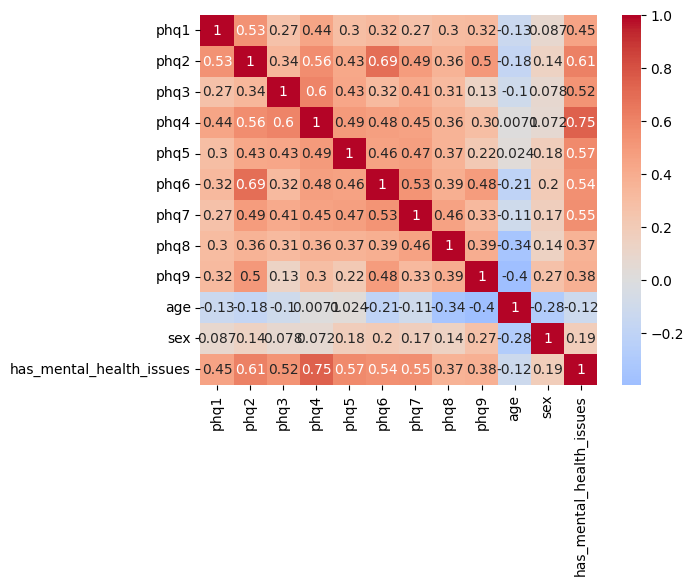

In [6]:
cont = ['phq1', 'phq2', 'phq3', 'phq4', 'phq5', 'phq6', 'phq7', 'phq8', 'phq9', 'age', 'sex', 'has_mental_health_issues']
corr_matrix = pd.DataFrame(df[cont],columns=cont).corr()
sns.heatmap(corr_matrix, annot=True, center=0, cmap='coolwarm')
plt.show()

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Load dataset
file_path = r"cleaned_anxiety_dataset.csv"
df = pd.read_csv(file_path)

# Drop 'id' column if it exists
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

# Compute GAD-7 total score
gad_columns = ['gad1','gad2','gad3','gad4','gad5','gad6','gad7']
df['gad7_total'] = df[gad_columns].sum(axis=1)

# Create binary label
df['anxiety_label'] = (df['gad7_total'] >= 10).astype(int)

# Encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(df[gad_columns])
y = df['anxiety_label']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train,y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("LogReg CV Accuracy Scores:", cv_scores)
print("LogReg Mean CV Accuracy:", cv_scores.mean())

# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print("LogReg ROC-AUC:", roc_auc_score(y_test,y_proba))
print("LogReg Report:\n", classification_report(y_test,y_pred))


LogReg CV Accuracy Scores: [0.99193548 0.99193548 1.         1.         1.        ]
LogReg Mean CV Accuracy: 0.9967741935483871
LogReg ROC-AUC: 1.0
LogReg Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       118
           1       1.00      0.97      0.99        38

    accuracy                           0.99       156
   macro avg       1.00      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156



In [8]:
background_data =  shap.sample(X_train, 10)

explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer(X_test)

np.shape(shap_values)

100%|██████████| 156/156 [00:00<00:00, 284.92it/s]


(156, 7, 2)

In [9]:
shap.plots.beeswarm(shap_values[:156,:,1], show=False)

fig = plt.gcf()

fig.set_size_inches(10, 8)

fig.savefig("lr_shap_1.pdf", dpi=300, bbox_inches='tight')

plt.close(fig)